# Derivation

## Euclidean

The key benefit here is something that can be computed using moments of the data, and is therefore amenable to integration with online optimization or other streaming data scenarios.

### Direct

This strategy directly integrates the level set condition.  The lower bound is shown here: the upper bound corresponds to negating $r$ everywhere and negating the result.

Assume no duplicates for now (infinitesmal futzing, $c_{w,r} = 0$ or $1$).
$$
\begin{alignat}{2}
&\!\min_{Q \succeq 0} &\qquad& \vec{w}^\top Q \vec{r},\label{eq:mleci}\\
&\text{subject to} &  & \vec{w}^\top Q \vec{1} = 1, \tag{$\beta$} \label{eq:mlecisumw} \\
&                  &  & \vec{1}^\top Q \vec{1} = 1, \tag{$\gamma$} \label{eq:mlecisum} \\
&                  &  & \sum_{n} \frac{1}{2} \left(N Q_{w_n,r_n} - 1\right)^2 \leq \Delta + \sum_{n} \frac{1}{2} \left(N Q^{\text{(mle)}}_{w_n,r_n} - 1\right)^2, \tag{$\kappa$}
\end{alignat}
$$

$$
\begin{aligned}
&L(\beta, \gamma, \kappa, Q) \\
&=\vec{w}^\top Q \vec{r} + \kappa \left(\sum_n \frac{1}{2} \left(N Q_{w_n,r_n} - 1\right)^2 - \Delta - \sum_n \frac{1}{2} \left(N Q^{\text{(mle)}}_{w_n,r_n} - 1\right)^2 \right) + \gamma \left(\vec{1}^\top Q \vec{1} - 1\right) + \beta \left( \vec{w}^\top Q \vec{1} - 1 \right) \\
&= \kappa \left( -\Delta - \sum_n \frac{1}{2} \left(N Q^{\text{(mle)}}_{w_n,r_n} - 1\right)^2 \right) -\gamma -\beta + \sum_{w,r} \left( \kappa c_{w,r} \frac{1}{2} \left(N Q_{w,r} - 1\right)^2 + \left(\gamma + \beta w + w r\right)Q_{w,r}\right), \\
\end{aligned}
$$ Dual will be unbounded unless $\forall w, r: \gamma + \beta w + w r \geq 0 \lor c_{w,r} > 0$.  With infinistemal futzing, this is equivalent to $\forall w, r: \gamma + \beta w + w r \geq 0$. $\gamma + \beta w + w r = 0$ can only happen either everywhere or at an extreme value of $w$, and with $r_{\min}$ (unless $w_{\min}=0$ but then $r_{\min}$ is sufficient to consider).  So we will only potentially place undata on an extreme point of $w$ associated with $r_{\min}$.  Continuing $\ldots$
<!---
\[Kappa] 1/2 (n q - 1)^2 + (\[Gamma] + \[Beta] w + w r) q 
Solve[D[%, q] == 0, q] // FullSimplify // Collect[#, n]&
%% /. %[[1]] // FullSimplify // Collect[#, n]&
--->
$$
\begin{aligned}
Q^*_{w,r} &= \max\left\{ 0, \frac{1}{N} - \frac{\gamma + \beta w + w r}{\kappa N^2} \right\} & (\kappa c_{w,r} > 0)
\end{aligned}
$$
The  max{0,…}  is difficult to deal with so ignore that for the purpose of finding closed-form expressions for the (approximate) dual variables. Continuing $\ldots$
$$
\begin{aligned}
g (\beta, \gamma, \kappa) &= \inf_{Q \succeq 0} L(Q, \beta, \gamma, \kappa) \\
&\geq \kappa \left( -\Delta - \sum_n -\frac{1}{2} \left(N Q^{\text{(mle)}}_{w_n,r_n} - 1\right)^2 \right) -\gamma -\beta + \sum_n \left( \frac{\gamma + \beta w_n + w_n r_n}{N} - \frac{\left(\gamma + \beta w_n + w_n r_n\right)^2}{2 N^2 \kappa} \right) \\
&= \kappa \left( -\Delta - \sum_n \frac{1}{2} \left(N Q^{\text{(mle)}}_{w_n,r_n} - 1\right)^2 \right) -\beta + \sum_n \left(\frac{\beta w_n + w_n r_n}{N} - \frac{\left(\gamma + \beta w_n + w_n r_n\right)^2}{2 N^2 \kappa} \right) \\
&= \overline{w r} - \kappa \phi + \beta \left(-1 + \overline{w}\right) - \sum_n \frac{\left(\gamma + \beta w_n + w_n r_n\right)^2}{2 N^2 \kappa}
\end{aligned}
$$


#### $\gamma^*$

The unconstrained $\gamma$ optimum is $-\frac{1}{N} \sum_n \left(\beta w_n + w_n r_n\right) = -\beta \overline{w} - \overline{w r}$ but this is infeasible.  Therefore maximizing $\gamma$ under the constraint is $$
\begin{aligned}
\forall w, r: \gamma &\geq -\beta w - w r \\
\gamma^* &= \max_{w,r} \left(-\beta w - w r \right) \\
&= \max_w \left(-\beta w - w r_{\min} \right) & (w \geq 0) \\
&= \begin{cases} 
-\left( \beta + r_{\min} \right) w_{\max} & \beta + r_{\min} < 0 \\
-\left( \beta + r_{\min} \right) w_{\min} & \beta + r_{\min} \geq 0
\end{cases} \\
&\doteq -\left( \beta + r_{\min} \right) w_{\text{ex}}
\end{aligned}
$$ Substituting
$$
\begin{aligned}
g(\beta, \kappa) &= \overline{w r} - \kappa \phi + \beta \left(-1 + \overline{w}\right) - \sum_n \frac{\left(\gamma + \beta w_n + w_n r_n\right)^2}{2 N^2 \kappa} \\
&= \overline{w r} - \kappa \phi + \beta \left(-1 + \overline{w}\right) - \sum_n \frac{\left(\beta (w_n - w_{\text{ex}}) + w_n r_n - w_{\text{ex}} r_{\min}\right)^2}{2 N^2 \kappa} \\
\end{aligned}
$$

#### $\kappa^*$

<!---
Maximize[{ a - \[Phi] \[Kappa] - c / \[Kappa], \[Kappa] >= 0, c >= 0, \[Phi] > 0 }, \[Kappa]]
--->
Rewrite the dual objective
$$
\begin{aligned}
g(\beta, \kappa) &= a(\beta) - \kappa \phi - \frac{1}{\kappa} c(\beta) \\
a(\beta) &\doteq \overline{w r} + \beta \left(-1 + \overline{w}\right) \\
c(\beta) &\doteq \sum_n \frac{\left(\beta (w_n - w_{\text{ex}}) + w_n r_n - w_{\text{ex}} r_{\min}\right)^2}{2 N^2} \\
\end{aligned}
$$ where $\phi > 0$ and $c(\beta) \geq 0$ are guaranteed by definition.  Thus
$$
\begin{aligned}
\kappa^*(\beta) &= \sqrt{\frac{c(\beta)}{\phi}} \\
g(\beta) &= a(\beta) - 2 \sqrt{c(\beta) \phi} \\
&= \overline{w r} + \beta \left(-1 + \overline{w}\right) - 2 \sqrt{\phi} \sqrt{\sum_n \frac{\left(\beta (w_n - w_{\text{ex}}) + w_n r_n - w_{\text{ex}} r_{\min}\right)^2}{2 N^2}} \\
\end{aligned}
$$

#### $\beta^*$ and $g^*$

$$
\begin{aligned}
g(\beta) &= \overline{w r} + \beta \left(-1 + \overline{w}\right) - 2 \sqrt{\frac{\phi}{N}} \sqrt{\frac{1}{2} \frac{1}{N} \sum_n \left(\beta (w_n - w_{\text{ex}}) + w_n r_n - w_{\text{ex}} r_{\min}\right)^2} \\
&= \overline{w r} + \beta \left(-1 + \overline{w}\right) - 2 \sqrt{\frac{\phi}{N}} \sqrt{\frac{1}{2} \beta^2 x_{\text{ex}} + \beta y_{\text{ex}} + \frac{1}{2} z_{\text{ex}}} \\
x_{ex} &\doteq \overline{w^2} - 2 w_{\text{ex}} \overline{w} + w_{\text{ex}}^2 \\
y_{ex} &\doteq \overline{w^2 r} - \overline{w r} w_{\text{ex}} - \overline{w} w_{\text{ex}} r_{\min} + w_{\text{ex}}^2 r_{\min} \\
z_{ex} &\doteq \overline{w^2 r^2} - 2 \overline{w r} w_{\text{ex}} r_{\min} + w_{\text{ex}}^2 r_{\min}^2
\end{aligned}
$$ Ignoring the dependence of $x_{ex}$, $y_{ex}$, and $z_{ex}$ on $\beta$ the maximizer is given by $$
\begin{aligned}
\beta^* &= 
\begin{cases}
\frac{-y_{ex}}{x_{ex}} & x_{ex} > 0 \land \overline{w} = 1 \\
\frac{1}{x_{ex}} \left( -y_{ex} + \frac{\left(-1 + \overline{w}\right)\sqrt{y_{ex}^2 - x_{ex} z_{ex}}}{\sqrt{\left(-1 + \overline{w}\right)^2 - \frac{2 x_{ex} \phi}{N}}} \right)  & x_{ex} > 0 \land \overline{w} \neq 1 \\
-\frac{z_{ex}}{y_{ex}} + \frac{\phi}{N} \frac{y_{ex}}{\left(-1 + \overline{w}\right)^2} & x_{ex} = 0 \land y_{ex} > 0 \land \overline{w} \neq 1 \\
\text{indeterminate} & \text{otherwise} \\
\end{cases}
\end{aligned}
$$ Both $\beta^* \leq -r_{\min}$ and $\beta^* \geq -r_{\min}$ have to be checked using the above formulas.  

Furthermore $\beta^* = -r_{\min}$ needs to be considered.  $\gamma^* = 0$ in this case thus the value of $w_{\text{ex}}$ is immaterial and $w_{\text{ex}} = w_{\min}$ is sufficient to consider.

The largest dual objective is the winner.

<!----
F + \[Beta] G -2 H Sqrt[1/2 X \[Beta]^2 +Y \[Beta] + 1/2 Z] 
D[%, \[Beta]]
Solve[% == 0, \[Beta]] // Simplify // PowerExpand // Simplify // FullSimplify
%% /. % // Simplify // PowerExpand
((%%%% /. %%[[2]] // Simplify // PowerExpand // Simplify ) /. G^2 -> K + 2 H^2 X // Simplify) /. K -> G^2 - 2 H^2 X // Collect[#, {F, Y}]&
% /. F -> wrbar /. G -> (-1 + wbar) /. H^2 -> \[Phi]/n
%%%%[[2]] /. F -> wrbar /. G -> (-1 + wbar) /. H^2 -> \[Phi]/n

F + \[Beta] G -2 H Sqrt[1/2 X \[Beta]^2 +Y \[Beta] + 1/2 Z]  /. X -> 0
D[%, \[Beta]]
Solve[% == 0, \[Beta]] // Simplify // PowerExpand // Simplify // FullSimplify
%% /. % // Simplify // PowerExpand
(%%%% /. %%[[1]] // FullSimplify // PowerExpand) /. F -> wrbar /. G -> (-1 + wbar) /. H^2 -> \[Phi]/n 
%%%[[1]] /. F -> wrbar /. G -> (-1 + wbar) /. H^2 -> \[Phi]/n 
--->

<!----
(\[Beta] (wn - wex) + wn rn - wex rmin)^2 // Expand // Collect[#, \[Beta]]& // TextForm
    2    2                        2   2
rmin  wex  - 2 rmin rn wex wn + rn  wn  + 
              2                                        2
   (2 rmin wex  - 2 rmin wex wn - 2 rn wex wn + 2 rn wn ) \[Beta] + 
       2                2   2
   (wex  - 2 wex wn + wn ) \[Beta]

---->

### Profile

One strategy is to search over the profile likelihood using the level set condition. Assume no duplicates for 
now (infinitesmal futzing, $c_{w,r} = 0$ or $1$).  The profile likelihood is $$
\begin{alignat}{2}
&\!\min_{Q \succeq 0} &\qquad& \sum_{n} \frac{1}{2} \left(N Q_{w_n,r_n} - 1\right)^2,\label{eq:mle}\\
&\text{subject to} &  & \vec{w}^\top Q \vec{1} = 1, \tag{$\beta$} \label{eq:mlesumw} \\
&                  &  & \vec{1}^\top Q \vec{1} = 1. \tag{$\gamma$} \label{eq:mlesum} \\
&                  &  & \vec{w}^\top Q \vec{r} = v. \tag{$\kappa$} \label{eq:mlesumwr}
\end{alignat}
$$
Langragian:
$$
\begin{aligned}
L(Q, \beta, \gamma) &= \beta  \left(\vec{w}^\top Q \vec{1} - 1\right) + \gamma \left(\vec{1} Q \vec{1} - 1\right) + \kappa \left( \vec{w}^\top Q \vec{r} - v\right) + \sum_{n} \frac{1}{2} \left(N Q_{w_n,r_n} - 1\right)^2. \\
&= -\beta - \gamma - \kappa v + \sum_{w,r} \left( \left( \gamma + \beta w + \kappa w r \right) Q_{w,r} + \frac{1}{2} c_{w,r} \left(N Q_{w,r} - 1\right)^2 \right). \\
\frac{\partial}{\partial Q_{w,r}} L(Q, \beta, \gamma, \kappa) &= \gamma + \beta w + \kappa w r + c_{w,r} N \left(N Q_{w,r} - 1\right) \\
\end{aligned}
$$ Dual will be unbounded unless $\forall w, r: \gamma + \beta w + \kappa w r \geq 0$.  Thus undata can only be placed at extreme points of $w r$.  Continuing $\ldots$
$$
\begin{aligned}
Q^*_{w,r} &= \max\left\{0, \frac{1}{N} - \frac{\gamma + \beta w + \kappa w r}{N^2}\right\} & (c_{w,r} = 1). \\
\end{aligned}
$$ The $\max\{0,\ldots\}$ is difficult to deal with so ignore that for the purpose of finding closed-form expressions for the (approximate) dual variables.  Continuing $\ldots$
$$
\begin{aligned}
g (\beta, \gamma, \kappa) &= \inf_{Q \succeq 0} L(Q, \beta, \gamma, \kappa) \\
&\geq -\beta - \gamma - \kappa v + \sum_n \left( \frac{\gamma + \beta w_n + \kappa w_n r_n}{N} - \frac{(\gamma + \beta w_n + \kappa w_n r_n)^2}{2 N^2} \right) \\
&= -\beta - \kappa v + \sum_n \left( \frac{\beta w_n + \kappa w_n r_n}{N} - \frac{(\gamma + \beta w_n + \kappa w_n r_n)^2}{2 N^2} \right) \\
\end{aligned}
$$ We can expand the lower into sufficient statistics $$
\begin{aligned}
&= -\beta - \kappa v + \beta \frac{1}{N} \sum_n w_n + \kappa \frac{1}{N} \sum_n w_n r_n -\frac{\gamma^2}{2 N} - \gamma \beta \frac{1}{N^2} \sum_n w_n - \gamma \kappa \frac{1}{N^2} \sum_n w_n r_n - \beta^2 \frac{1}{2 N^2} \sum_n w_n^2 - \beta \kappa \frac{1}{N^2} \sum_n w_n^2 r_n - \kappa^2 \frac{1}{2 N^2} \sum_n w_n^2 r_n^2 \\
&\doteq -\beta - \kappa v + \beta \overline{w} + \kappa \overline{w r} -\frac{\gamma^2}{2 N} - \gamma \beta \frac{1}{N} \overline{w} - \gamma \kappa \frac{1}{N} \overline{w r} - \beta^2 \frac{1}{2 N} \overline{w^2} - \beta \kappa \frac{1}{N} \overline{w^2 r} - \kappa^2 \frac{1}{2 N} \overline{w^2 r^2} \\
&= \frac{1}{2} \left( \begin{matrix} \gamma \\ \beta \\ \kappa \end{matrix} \right)^\top \left(
\begin{matrix} -\frac{1}{N} & -\frac{1}{N} \overline{w} & -\frac{1}{N} \overline{w r} \\ 
-\frac{1}{N} \overline{w} & -\frac{1}{N} \overline{w^2} & -\frac{1}{N} \overline{w^2 r} \\ 
-\frac{1}{N} \overline{w r} & -\frac{1}{N} \overline{w^2 r} & -\frac{1}{N} \overline{w^2 r^2}
\end{matrix} \right) \left( \begin{matrix} \gamma \\ \beta \\ \kappa \end{matrix} \right) - \left(\begin{matrix} 0 & 1 - \overline{w} & v - \overline{w r} \end{matrix}\right)^\top \left( \begin{matrix} \gamma \\ \beta \\ \kappa \end{matrix} \right)
\end{aligned}
$$ This is a quadratic program with 4 linear inequality constraints $\{ \gamma + \beta w + \kappa w r \geq 0 | w \in \{w_\min, w_\max \}, r \in \{ r_\min, r_\max \} \}$.

If there were no duality gap, the value of the dual objective at the optimum can be compared to the level set threshold and we can bisect on $v$ to find the extreme values of the interval. Because we are optimizing a lower bound on the dual there is a duality gap with the original primal, so calibration is an issue.

# Comparison with baselines

In [14]:
class CITest:
    class ClopperPearson:
        @staticmethod
        def interval(data, wmax, alpha, **kwargs):    
            from scipy.special import betaincinv

            k = sum((c*w/wmax)*r for c, w, r in data)
            n = sum(c for c, w, _ in data)

            lb = betaincinv(k, n - k + 1, alpha/2) if k > 0 and n - k + 1 > 0 else 0
            ub = betaincinv(k + 1, n - k, 1-alpha/2) if n > k else 1

            return min(1, lb*wmax), min(1, ub*wmax)  
        
    class AsymptoticGaussian:
        def interval(data, wmax, alpha, **kwargs):
            from math import sqrt
            from scipy.stats import norm  
            
            scale = norm.ppf(1-alpha/2)
 
            n = sum(c for c, _, _ in data)
            tot = sum(c*w*r for c, w, r in data)
            muhat = tot / n
            totsq = sum(c*(w*r - muhat)**2 for c, w, r in data)
            sigmahat = sqrt(totsq) / n
            
            return max(0, muhat - scale*sigmahat), min(1, muhat + scale*sigmahat)
        
    class Euclidean:
        class Profile:
            def __init__(self, n, barw, barwsq, barwr, barwsqr, barwsqrsq, wmin, wmax, rmin=0, rmax=1):
                import numpy
                
                G = (1/n) * numpy.array( ( 
                                           ( 1, barw, barwr ),
                                           ( barw, barwsq, barwsqr ),
                                           ( barwr, barwsqr, barwsqrsq ) 
                                       ) )
                Geigen = numpy.linalg.eigvalsh(G)
                maxev = max(Geigen)
                minev = min(Geigen)
                condfac = 1e-6
                targetev = condfac * maxev
                if targetev > minev:
                    G += (targetev - minev) * numpy.eye(3)
                    
                self.G = G
                self.C = numpy.array([ (1.0, w, w * r) for w in (wmin, wmax) for r in (rmin, rmax) ])
                self.b = numpy.array([ 0.0 for w in (wmin, wmax) for r in (rmin, rmax) ])
                
                self.n = n
                self.barw = barw
                self.barwr = barwr
                self.barwsq = barwsq
                self.barwsqr = barwsqr
                self.wmin = wmin
                self.wmax = wmax
                self.rmin = rmin
                self.rmax = rmax
                
            def profile(self, v):
                import numpy
                from quadprog import solve_qp
                
                a = numpy.array( (0, self.barw - 1, self.barwr - v ) )
                sol = solve_qp(self.G, a, self.C.T, self.b)

                return { 'dualobjective': -sol[1], 
                         'gammastar': sol[0][0], 
                         'betastar': sol[0][1], 
                         'kappastar': sol[0][2],
                       }
            
            def solve(self, alpha):
                from scipy.stats import f
                import numpy

                # NB: profile maximizer corresponds to \kappa^* = 0, can be solved analytically
                wextreme = self.wmin if self.barw > 1 else self.wmax
                denom = self.barwsq - 2 * wextreme * self.barw + wextreme * wextreme
                uncdual = self.n * (self.barw - 1)**2 / (2 * denom)
                uncbetastarovern = (self.barw - 1) / denom
                uncgammastarovern = -uncbetastarovern * wextreme
                vmle = max(self.rmin, min(self.rmax, self.barwr - uncgammastarovern * self.barwr - uncbetastarovern * self.barwsqr))

                Delta = 0.5 * f.isf(q=alpha, dfn=1, dfd=self.n-1)

                def feasiblefunc(v):
                    vprofile = self.profile(v)
                    return vprofile['dualobjective'] - uncdual - Delta

                if vmle < self.rmax and feasiblefunc(self.rmax) > 0:
                    from scipy.optimize import root_scalar
                    rootresult = root_scalar(feasiblefunc, bracket=(vmle, self.rmax))
                    assert rootresult.converged, print(pformat({
                        'rootresult': rootresult,
                    }))
                    vub = rootresult.root
                else:
                    vub = self.rmax

                if self.rmin < vmle and feasiblefunc(self.rmin) > 0:
                    from scipy.optimize import root_scalar
                    rootresult = root_scalar(feasiblefunc, bracket=(self.rmin, vmle))
                    assert rootresult.converged, print(pformat({
                        'rootresult': rootresult,
                    }))
                    vlb = rootresult.root
                else:
                    vlb = self.rmin

                return vlb, vub

        class DirectInterval:
            def __init__(self, n, barw, barwsq, barwr, barwsqr, barwsqrsq, wmin, wmax, rmin=0, rmax=1):
                self.n = n
                self.barw = barw
                self.barwsq = barwsq
                self.barwr = barwr
                self.barwsqr = barwsqr
                self.barwsqrsq = barwsqrsq
                self.wmin = wmin
                self.wmax = wmax
                self.rmin = rmin
                self.rmax = rmax
            
            def solve(self, alpha):
                lb = self.solvesigned(alpha, 1)
                ub = self.solvesigned(alpha, -1)
                
                return lb['v'], ub['v']
            
            def solvesigned(self, alpha, sign):
                from math import sqrt
                from scipy.stats import f
                
                # NB: profile maximizer corresponds to \kappa^* = 0, can be solved analytically
                wextreme = self.wmin if self.barw > 1 else self.wmax
                denom = self.barwsq - 2 * wextreme * self.barw + wextreme * wextreme
                uncdual = self.n * (self.barw - 1)**2 / (2 * denom)
                
                Delta = 0.5 * f.isf(q=alpha, dfn=1, dfd=self.n-1)
                phi = uncdual + Delta
                
                rex = self.rmin if sign > 0 else self.rmax
                
                xplus = self.barwsq - 2 * sign * self.wmin * self.barw + self.wmin**2 
                xminus = self.barwsq - 2 * sign * self.wmax * self.barw + self.wmax**2
                yplus = self.barwsqr - self.wmin * self.barwr - self.barw * self.wmin * rex + self.wmin**2 * rex
                yminus = self.barwsqr - self.wmax * self.barwr - self.barw * self.wmax * rex + self.wmax**2 * rex
                zplus = self.barwsqrsq - 2 * self.barwr * self.wmin * rex + self.wmin**2 * rex**2
                zminus = self.barwsqrsq - 2 * self.barwr * self.wmax * rex + self.wmax**2 * rex**2
                sqrtphiovern = sqrt(phi / self.n)
                
                def megabetafunc(beta, x, y, z):
                    from math import sqrt
                    
                    sqrtterm = 0.5 * x * beta**2 + sign * y * beta + 0.5 * z
                    sqrtterm = max(0, sqrtterm)
                    
                    return -( sign * self.barwr + beta * (-1 + self.barw) - 2 * sqrtphiovern * sqrt(sqrtterm) )
                
                def betafunc(beta):
                    return megabetafunc(beta, xplus, yplus, zplus) if beta + sign * rex >= 0 else \
                           megabetafunc(beta, xminus, yminus, zminus)
                
                candidates = [ ( 1, -sign * rex, megabetafunc(-sign * rex, xplus, yplus, zplus) ) ]
                for (x, y, z, s) in ( (xplus, yplus, zplus, 1), (xminus, yminus, zminus, -1) ):
                    if x > 0:
                        if self.barw == 1:
                            betastar = -sign * y / x
                            candidates.append( (s, betastar, megabetafunc(betastar, x, y, z)) )
                        else:
                            numsqrt = y**2 - x * z
                            denomsqrt = (-1 + self.barw)**2 - 2 * x * phi / self.n
                            if numsqrt == 0 or numsqrt * denomsqrt > 0:
                                from math import sqrt
                                sqrtfac = sqrt(numsqrt / denomsqrt)
                                betastar = (-sign * y + (-1 + self.barw) * sqrtfac) / x
                                candidates.append( (s, betastar, megabetafunc(betastar, x, y, z)) )
                    elif y > 0:
                        if self.barw != 1:
                            betastar = -z / (2 * sign * y) + (phi / self.n) * (sign * y / (-1 + self.barw)**2)
                            candidates.append( (s, betastar, megabetafunc(betastar, x, y, z)) )
                 
                optimum = min( ( (s, x, fx) for s, x, fx in candidates if s * (x + sign * rex) >= 0 ),
                               key = lambda x: x[2] )
                plusorminus = optimum[0] > 0
                betastar = optimum[1]
                vstar = -sign * optimum[2]
                
                if False:
                    from scipy.optimize import minimize_scalar
                    optresult = minimize_scalar(betafunc, bracket=(-sign * rex - 0.5, -sign * rex + 0.5))
                    from pprint import pformat
                    assert optresult.success, pformat(optresult)
                    betastar = optresult.x
                    import numpy
                    assert numpy.allclose(betastar, optimum[1], atol=1e-5), pformat(
                    {
                        'optresult': optresult,
                        'optimum': optimum,
                        'candidates': [ (s, x, fx, s * (x + sign * rex) >= 0) for s, x, fx in candidates ],
                        'profile': CITest.Euclidean.Profile(self.n, self.barw, self.barwsq, self.barwr, 
                                                            self.barwsqr, self.barwsqrsq, self.wmin, self.wmax).solve(alpha),
                    })
                    vstar = -sign * optresult.fun
                    plusorminus = betastar + sign * rex >= 0

                wex = self.wmin if plusorminus else self.wmax    
                gammastar = -(betastar + sign * rex) * wex
                cbeta = (
                    0.5 * betastar**2 * (xplus if plusorminus else xminus)
                    + betastar * sign * (yplus if plusorminus else yminus)
                    + 0.5 * (zplus if plusorminus else zminus)
                ) / self.n
                cbeta = max(0, cbeta)
                kappastar = sqrt(cbeta / phi)
                
                return { 'v': max(self.rmin, min(self.rmax, vstar)),
                         'betastar': betastar,
                         'gammastar': gammastar,
                         'kappastar': kappastar,
                       }
                
        @staticmethod
        def interval(data, wmax, alpha, **kwargs):                
            n = sum(c for c, _, _ in data)
            barw = sum(c * w for c, w, _ in data) / n
            barwsq = sum(c * w**2 for c, w, _ in data) / n
            barwr = sum(c * w * r for c, w, r in data) / n
            barwsqr = sum(c * w**2 * r for c, w, r in data) / n
            barwsqrsq = sum(c * w**2 * r**2 for c, w, r in data) / n
            
#             profile = CITest.Euclidean.Profile(n, barw, barwsq, barwr, barwsqr, barwsqrsq, 0, wmax)
#             return profile.solve(alpha)
            
            direct = CITest.Euclidean.DirectInterval(n, barw, barwsq, barwr, barwsqr, barwsqrsq, 0, wmax)
            return direct.solve(alpha)
            
if False:
    for mydata in [
        [(2, 1.0101010101010102, 1), (8, 0, 0)],
        [(10, 1.0101010101010102, 1), (1, 1.0101010101010102, 0)],
        [(1, 0, 0), (99, 1000/999, 1)],
        [(21, 0.0, 0), (247, 1.0101010101010102, 0), (1, 1000.0, 0)],
        [(10, 2, 0)],
        [(6, 0, 0), (4, 2, 1)],
        [(5428, 0, 0), (872, 2, 0), (3700, 2, 1)],
        [(5516, 0, 0), (4181, 2, 0), (303, 2, 1)],
        [(5514, 0, 0), (4073, 2, 0), (411, 2, 1), (2, 1000, 1)],
        [(5532, 0, 0), (2936, 2, 0), (1528, 2, 1), (4, 1000, 1)],
        [(5532, 0, 0), (2936, 2, 0), (1528, 2, 1), (10, 1000, 1)],
    ]:
        from importlib import reload
        import MLE.MLE

        reload(MLE.MLE)

        print("****")
        print(mydata)
#         print(CITest.ClopperPearson.interval(mydata, wmax=1000, alpha=0.05))
#         print(CITest.AsymptoticGaussian.interval(mydata, wmax=1000, alpha=0.05))
#         print(MLE.MLE.asymptoticconfidenceinterval(datagen=lambda: mydata, wmin=0, wmax=1000, alpha=0.05))
        print(CITest.Euclidean.interval(data=mydata, wmin=0, wmax=1000, alpha=0.05))
        from timeit import timeit
        print(timeit(stmt=lambda: CITest.Euclidean.interval(data=mydata, wmin=0, wmax=1000, alpha=0.05), number=1000))

In [15]:
from importlib import reload
import environments.ControlledRangeVariance
import MLE.MLE

reload(environments.ControlledRangeVariance)
reload(MLE.MLE)

def produceresults(env, method, minexp=1, maxexp=6, numpts=15, ndataperpt=100):
    from math import ceil
    import numpy
    
    wmin, wmax = env.range()

    for ndata in map(ceil, numpy.logspace(minexp, maxexp, numpts)):
        bounds=[]
        for i in range(1, ndataperpt+1):
            (truevalue, data) = env.sample(ndata)

            try:
                ci = method(data=data, wmin=wmin, wmax=wmax, alpha=0.05)
                assert numpy.isfinite(ci[0]) and numpy.isfinite(ci[1])
#                 assert ci[1] >= ci[0]
#                 assert ci[1] >= truevalue
#                 assert ci[0] <= truevalue
            except:
                print('truevalue was {}'.format(truevalue))
                print('data was {}'.format(data))
                print('wmin, wmax was {} {}'.format(wmin, wmax))
                print('ci was {}'.format(ci))
                raise
                                                
            bounds.append(
                ( truevalue,
                  data,
                  [ 
                      ci[0], 'n/a', ci[1]
                  ]
                )  
            )
            
        uppers = [ d[2][2] for d in bounds ]
        lowers = [ d[2][0] for d in bounds ]
        upperbounded = [ 1 if d[0] <= d[2][2] else 0 for d in bounds ]
        lowerbounded = [ 1 if d[2][0] <= d[0] else 0 for d in bounds ]
        covered = [ 1 if u*l > 0 else 0 for (u, l) in zip(upperbounded, lowerbounded) ]
        width = [ d[2][2] - d[2][0] for d in bounds ]    
        yield (ndata,
                { 
                    'coverage': round(sum(covered) / len(covered), 4),
                    'ubcoverage': round(sum(upperbounded) / len(upperbounded), 4),
                    'lbcoverage': round(sum(lowerbounded) / len(lowerbounded), 4),
                    'width': round(sum(width) / len(width), 4),
                    'avub': round(sum(uppers) / len(uppers), 4),
                    'avlb': round(sum(lowers) / len(lowers), 4),
                },
              )

def getenv():
    wsupport = [ 0, 2, 1000 ]
    env = environments.ControlledRangeVariance.ControlledRangeVariance(seed=45, wsupport=wsupport, expwsq=100)
    return env, env.getpw(), env.range(), env.expectedwsq()
    
print(getenv()[2:])
wmax = getenv()[2][1]

allres = []
for (name, method) in [ 
                        ('Binomial CI', lambda data, wmax, alpha, **kwargs: CITest.ClopperPearson.interval(data, wmax, alpha)),
                        ('Asymptotic Gaussian', lambda data, wmax, alpha, **kwargs: CITest.AsymptoticGaussian.interval(data, wmax, alpha)),
                        ('Euclidean', lambda data, wmax, alpha, **kwargs: CITest.Euclidean.interval(data, wmax, alpha)),
                        ('MLE CI', lambda data, **kwargs: MLE.MLE.asymptoticconfidenceinterval(datagen=lambda: data, **kwargs)[0]),

                      ]:
    print('****** {} ******'.format(name))
    res = []
    for zzz in produceresults(getenv()[0], method, minexp=1, ndataperpt=10000, numpts=20):
        res.append(zzz)
        print('{}'.format(zzz), flush=True)
    allres.append((name, res))
import pickle
pickle.dump( allres, open( "epsilongreedy_ci_allres.p", "wb" ) )

((0, 1000), 99.99999410674329)
****** Binomial CI ******
(10, {'coverage': 0.9998, 'ubcoverage': 1.0, 'lbcoverage': 0.9998, 'width': 0.9998, 'avub': 1.0, 'avlb': 0.0002})
(19, {'coverage': 0.9991, 'ubcoverage': 1.0, 'lbcoverage': 0.9991, 'width': 0.9991, 'avub': 1.0, 'avlb': 0.0009})
(34, {'coverage': 0.9993, 'ubcoverage': 1.0, 'lbcoverage': 0.9993, 'width': 0.9991, 'avub': 1.0, 'avlb': 0.0009})
(62, {'coverage': 0.9988, 'ubcoverage': 1.0, 'lbcoverage': 0.9988, 'width': 0.9986, 'avub': 1.0, 'avlb': 0.0014})
(113, {'coverage': 0.9985, 'ubcoverage': 1.0, 'lbcoverage': 0.9985, 'width': 0.9986, 'avub': 1.0, 'avlb': 0.0014})
(207, {'coverage': 0.9988, 'ubcoverage': 1.0, 'lbcoverage': 0.9988, 'width': 0.9981, 'avub': 1.0, 'avlb': 0.0019})
(380, {'coverage': 0.9996, 'ubcoverage': 1.0, 'lbcoverage': 0.9996, 'width': 0.9976, 'avub': 1.0, 'avlb': 0.0024})
(696, {'coverage': 0.9999, 'ubcoverage': 1.0, 'lbcoverage': 0.9999, 'width': 0.9957, 'avub': 1.0, 'avlb': 0.0043})
(1275, {'coverage': 0.9996,

(1275, {'coverage': 0.9926, 'ubcoverage': 0.997, 'lbcoverage': 0.9956, 'width': 0.1721, 'avub': 0.5859, 'avlb': 0.4138})
(2336, {'coverage': 0.9931, 'ubcoverage': 0.9968, 'lbcoverage': 0.9963, 'width': 0.1485, 'avub': 0.5775, 'avlb': 0.429})
(4282, {'coverage': 0.9891, 'ubcoverage': 0.9957, 'lbcoverage': 0.9934, 'width': 0.1293, 'avub': 0.5659, 'avlb': 0.4366})
(7848, {'coverage': 0.9807, 'ubcoverage': 0.9902, 'lbcoverage': 0.9905, 'width': 0.1114, 'avub': 0.554, 'avlb': 0.4426})
(14385, {'coverage': 0.9711, 'ubcoverage': 0.9855, 'lbcoverage': 0.9856, 'width': 0.094, 'avub': 0.5486, 'avlb': 0.4546})
(26367, {'coverage': 0.965, 'ubcoverage': 0.9823, 'lbcoverage': 0.9827, 'width': 0.0771, 'avub': 0.5379, 'avlb': 0.4607})
(48330, {'coverage': 0.9522, 'ubcoverage': 0.978, 'lbcoverage': 0.9742, 'width': 0.0609, 'avub': 0.5312, 'avlb': 0.4702})
(88587, {'coverage': 0.9509, 'ubcoverage': 0.9719, 'lbcoverage': 0.979, 'width': 0.0471, 'avub': 0.5209, 'avlb': 0.4738})
(162378, {'coverage': 0.946

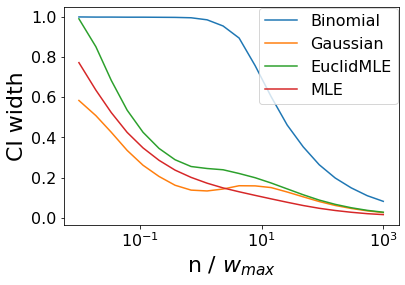

In [64]:
%matplotlib inline

class FlassPlot:
    from matplotlib import scale as mscale
    
    class ExpScale(mscale.ScaleBase):
        from matplotlib import transforms as mtransforms

        """
        Scales data in range -Infinity, 1 using log(1 - x)
        """

        # The scale class must have a member ``name`` that defines the
        # string used to select the scale.  For example,
        # ``gca().set_yscale("mercator")`` would be used to select this
        # scale.
        name = 'exp'

        def __init__(self, axis, **kwargs):
            """
            Any keyword arguments passed to ``set_xscale`` and
            ``set_yscale`` will be passed along to the scale's
            constructor.
            """
            from matplotlib import scale as mscale
            myscale = kwargs.pop("expscale", 1.0)
            mscale.ScaleBase.__init__(self, axis, **kwargs)
            self.myscale = myscale

        def get_transform(self):
            """
            Override this method to return a new instance that does the
            actual transformation of the data.
            """
            return FlassPlot.ExpScale.ExpTransform(self.myscale)

        def set_default_locators_and_formatters(self, axis):
            """
            Override to set up the locators and formatters to use with the
            scale.  This is only required if the scale requires custom
            locators and formatters.  Writing custom locators and
            formatters is rather outside the scope of this example, but
            there are many helpful examples in ``ticker.py``.

            In our case, the Mercator example uses a fixed locator from
            -90 to 90 degrees and a custom formatter class to put convert
            the radians to degrees and put a degree symbol after the
            value::
            """

            return axis

        def limit_range_for_scale(self, vmin, vmax, minpos):
            """
            Override to limit the bounds of the axis to the domain of the
            transform.
            """
            return vmin, vmax

        class ExpTransform(mtransforms.Transform):
            # There are two value members that must be defined.
            # ``input_dims`` and ``output_dims`` specify number of input
            # dimensions and output dimensions to the transformation.
            # These are used by the transformation framework to do some
            # error checking and prevent incompatible transformations from
            # being connected together.  When defining transforms for a
            # scale, which are, by definition, separable and have only one
            # dimension, these members should always be set to 1.
            input_dims = 1
            output_dims = 1
            is_separable = True

            def __init__(self, scale):
                from matplotlib import transforms as mtransforms
                
                mtransforms.Transform.__init__(self)
                self.scale = scale

            def transform_non_affine(self, a):
                """
                This transform takes an Nx1 ``numpy`` array and returns a
                transformed copy.  Since the range of the Mercator scale
                is limited by the user-specified threshold, the input
                array must be masked to contain only valid values.
                ``matplotlib`` will handle masked arrays and remove the
                out-of-range data from the plot.  Importantly, the
                ``transform`` method *must* return an array that is the
                same shape as the input array, since these values need to
                remain synchronized with values in the other dimension.
                """
                import numpy as np
                
                return np.exp(self.scale * a)

            def inverted(self):
                """
                Override this method so matplotlib knows how to get the
                inverse transform for this transform.
                """
                return FlassPlot.ExpScale.InvertedExpTransform(self.scale)

        class InvertedExpTransform(mtransforms.Transform):
            input_dims = 1
            output_dims = 1
            is_separable = True

            def __init__(self, scale):
                from matplotlib import transforms as mtransforms
                
                mtransforms.Transform.__init__(self)
                self.scale = scale

            def transform_non_affine(self, a):
                import numpy as np
                
                return np.log(a / self.scale)

            def inverted(self):
                return FlassPlot.ExpScale.ExpTransform(self.scale)

    @staticmethod
    def yo():
        import matplotlib.pyplot as plt
        plt.figure(figsize=(4,2))
        
    @staticmethod
    def forpaper():
        import matplotlib.pyplot as plt
        from matplotlib import scale as mscale

        mscale.register_scale(FlassPlot.ExpScale)

        SMALL_SIZE = 16
        MEDIUM_SIZE = 22
        BIGGER_SIZE = 24

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    @staticmethod
    def exppic(x, y, label, expscale, **kwargs):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as ticker
        plt.ylim(0.0, 1.01)
        plt.plot(x, y, label=label, **kwargs)
        plt.gca().set_xscale('log')
        plt.gca().set_yscale('exp', expscale=expscale)
        plt.ylim(0.0, 1.01)
        plt.gca().yaxis.set_major_locator(ticker.FixedLocator([0.38,0.68,0.86,0.95,1]))

        plt.legend()
        
    @staticmethod
    def pic(x, y, label): 
        import matplotlib.pyplot as plt
        plt.semilogx(x, y, label=label)

        #plt.loglog(x, y, label=label)
        plt.legend()
        
    @staticmethod
    def axeslabel(xlabel, ylabel):  
        import matplotlib.pyplot as plt
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    @staticmethod
    def title(title):
        import matplotlib.pyplot as plt
        plt.title(title)
        
    @staticmethod
    def legend(**kwargs):
        import matplotlib.pyplot as plt
        plt.legend(**kwargs)
        
    @staticmethod
    def savefig(filename):
        import matplotlib.pyplot as plt
        plt.savefig(filename, bbox_inches='tight')

import pickle
allres = pickle.load(open( "epsilongreedy_ci_allres.p", "rb" ) )

renameit = { "Binomial CI": "Binomial", "Asymptotic Gaussian": "Gaussian", "MLE CI": "MLE", "Euclidean": "EuclidMLE" }
FlassPlot.forpaper()
for name, res in allres:
    FlassPlot.pic([ x[0] / wmax for x in res ], [ x[1]['width'] for x in res ], label=renameit.get(name, name))
FlassPlot.legend(loc="center", bbox_to_anchor=[0.79,0.775])
FlassPlot.axeslabel('n / $w_{max}$', 'CI width')

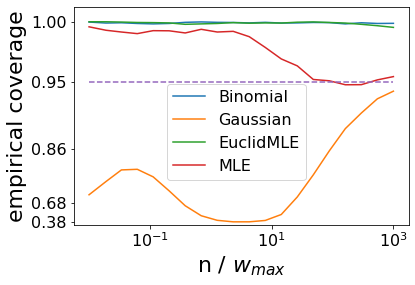

In [65]:
%matplotlib inline

import pickle
del allres
allres = pickle.load(open( "epsilongreedy_ci_allres.p", "rb" ) )

renameit = { "Binomial CI": "Binomial", "Asymptotic Gaussian": "Gaussian", "MLE CI": "MLE", "Euclidean": "EuclidMLE" }
FlassPlot.forpaper()
for name, res in allres:
    FlassPlot.exppic([ x[0] / wmax for x in res ], [ x[1]['coverage'] for x in res ], label=renameit.get(name,name), expscale=7.0)
FlassPlot.exppic([ x[0] / wmax for x in res ], [ 0.95 for x in res ], label='_nolegend_', expscale=7.0, ls='dashed')
FlassPlot.legend(loc="center", bbox_to_anchor=[0.485,0.425])
FlassPlot.axeslabel('n / $w_{max}$', 'empirical coverage')

In [5]:
from importlib import reload
import environments.ControlledRangeVariance
import MLE.MLE

reload(environments.ControlledRangeVariance)
reload(MLE.MLE)

def megaproduceresults(env, method):
    from math import ceil
    import numpy
    
    wmin, wmax = env.range()

    for ndata in [100000]:
        bounds=[]
        for i in range(1, 101):
            (truevalue, data) = env.sample(ndata)

            try:
                ci = method(data=data, wmin=wmin, wmax=wmax, alpha=0.05)
                assert numpy.isfinite(ci[0]) and numpy.isfinite(ci[1])
#                 assert ci[1] >= ci[0]
#                 assert ci[1] >= truevalue
#                 assert ci[0] <= truevalue
            except:
                print('truevalue was {}'.format(truevalue))
                print('data was {}'.format(data))
                print('ci was {}'.format(ci))
                raise
                                                
            bounds.append(
                ( truevalue,
                  data,
                  [ 
                      ci[0], 'n/a', ci[1]
                  ]
                )  
            )
            
        uppers = [ d[2][2] for d in bounds ]
        lowers = [ d[2][0] for d in bounds ]
        upperbounded = [ 1 if d[0] <= d[2][2] else 0 for d in bounds ]
        lowerbounded = [ 1 if d[2][0] <= d[0] else 0 for d in bounds ]
        covered = [ 1 if u*l > 0 else 0 for (u, l) in zip(upperbounded, lowerbounded) ]
        width = [ d[2][2] - d[2][0] for d in bounds ]    
        yield (ndata,
                { 
                    'coverage': round(sum(covered) / len(covered), 4),
                    'ubcoverage': round(sum(upperbounded) / len(upperbounded), 4),
                    'lbcoverage': round(sum(lowerbounded) / len(lowerbounded), 4),
                    'width': round(sum(width) / len(width), 4),
                    'avub': round(sum(uppers) / len(uppers), 4),
                    'avlb': round(sum(lowers) / len(lowers), 4),
                },
              )

def getenv(expwsq):
    import numpy
    wsupport = [ 0, 2, 1000 ]
    env = environments.ControlledRangeVariance.ControlledRangeVariance(seed=45, wsupport=wsupport, expwsq=expwsq)
    return env, env.getpw(), env.range(), env.expectedwsq()
    
allres = []
for (name, method) in [ ('Binomial', lambda data, wmax, alpha, **kwargs: CITest.ClopperPearson.interval(data, wmax, alpha)),
                        ('MLE', lambda data, **kwargs: MLE.MLE.asymptoticconfidenceinterval(datagen=lambda: data, **kwargs)[0]),
                      ]:
    import numpy
    print('****** {} ******'.format(name))
    res = []
    for expwsq in numpy.linspace(100, 999, 10):
        for zzz in megaproduceresults(getenv(expwsq)[0], method):
            res.append((expwsq, zzz))
            print('{}'.format((expwsq, zzz)), flush=True)
    allres.append((name, res))
import pickle
pickle.dump( allres, open( "epsilongreedy_ci_expwsqsweep.p", "wb" ) )

****** Binomial ******
(100.0, (100000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.2635, 'avub': 0.667, 'avlb': 0.4035}))
(199.88888888888889, (100000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.2573, 'avub': 0.6378, 'avlb': 0.3805}))
(299.77777777777777, (100000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.2667, 'avub': 0.7038, 'avlb': 0.4371}))
(399.66666666666663, (100000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.2556, 'avub': 0.6389, 'avlb': 0.3833}))
(499.55555555555554, (100000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.2584, 'avub': 0.6582, 'avlb': 0.3997}))
(599.4444444444445, (100000, {'coverage': 0.98, 'ubcoverage': 0.99, 'lbcoverage': 0.99, 'width': 0.2608, 'avub': 0.649, 'avlb': 0.3881}))
(699.3333333333333, (100000, {'coverage': 0.99, 'ubcoverage': 0.99, 'lbcoverage': 1.0, 'width': 0.2445, 'avub': 0.5947, 'avlb': 0.3502}))
(799.2222222222222, (100000, {

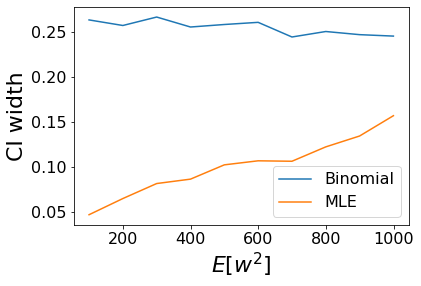

In [6]:
import pickle
allres = pickle.load(open( "epsilongreedy_ci_expwsqsweep.p", "rb" ) )

%matplotlib inline
        
class MegaFlassPlot:
    @staticmethod
    def forpaper():
        import matplotlib.pyplot as plt

        SMALL_SIZE = 16
        MEDIUM_SIZE = 22
        BIGGER_SIZE = 24

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    @staticmethod
    def pic(x, y, label):
        import matplotlib.pyplot as plt
        
        plt.plot(x, y, label=label)
        plt.legend()
        
    @staticmethod
    def axeslabel(xlabel, ylabel):
        import matplotlib.pyplot as plt
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    @staticmethod
    def title(title):
        import matplotlib.pyplot as plt
        
        plt.title(title)
        
    @staticmethod
    def savefig(filename):
        import matplotlib.pyplot as plt
        
        plt.savefig(filename, bbox_inches='tight')       

MegaFlassPlot.forpaper()
for name, res in allres:
    MegaFlassPlot.pic([ x[0] for x in res], [ x[1][1]['width'] for x in res], label=name)
MegaFlassPlot.axeslabel('$E[w^2]$', 'CI width')

In [7]:
from importlib import reload
import environments.Chirpy
import MLE.MLE

reload(environments.Chirpy)
reload(MLE.MLE)

def megaproduceresults(env, method):
    from math import ceil
    import numpy
    
    wmin, wmax = env.range()

    for ndata in [10000]:
        bounds=[]
        for i in range(1, 101):
            (truevalue, data) = env.sample(ndata)

            try:
                ci = method(data=data, wmin=wmin, wmax=wmax, alpha=0.05)
                expwsq = sum(c*w*w for c, w, _ in data) / sum(c for c, _, _ in data)
                assert numpy.isfinite(ci[0]) and numpy.isfinite(ci[1])
#                 assert ci[1] >= ci[0]
#                 assert ci[1] >= truevalue
#                 assert ci[0] <= truevalue
            except:
                print('truevalue was {}'.format(truevalue))
                print('data was {}'.format(data))
                print('ci was {}'.format(ci))
                raise
                                                
            bounds.append(
                ( truevalue,
                  data,
                  [ 
                      ci[0], 'n/a', ci[1]
                  ],
                  expwsq
                )  
            )
            
        uppers = [ d[2][2] for d in bounds ]
        lowers = [ d[2][0] for d in bounds ]
        upperbounded = [ 1 if d[0] <= d[2][2] else 0 for d in bounds ]
        lowerbounded = [ 1 if d[2][0] <= d[0] else 0 for d in bounds ]
        covered = [ 1 if u*l > 0 else 0 for (u, l) in zip(upperbounded, lowerbounded) ]
        width = [ d[2][2] - d[2][0] for d in bounds ]
        expwsqds = [d[3] for d in bounds]
        yield (ndata,
                { 
                    'coverage': round(sum(covered) / len(covered), 4),
                    'ubcoverage': round(sum(upperbounded) / len(upperbounded), 4),
                    'lbcoverage': round(sum(lowerbounded) / len(lowerbounded), 4),
                    'width': round(sum(width) / len(width), 4),
                    'avub': round(sum(uppers) / len(uppers), 4),
                    'avlb': round(sum(lowers) / len(lowers), 4),
                    'avexpwsq': round(sum(expwsqds) / len(expwsqds), 4),
                },
              )

def getenv(numimp):
    import numpy
    wsupport = [ 0, 2, 1000 ]
    env = environments.Chirpy.Chirpy(seed=45, wsupport=wsupport, expwsq=200, nchirp=numimp // 3)
    return env, env.getpw(), env.range(), env.expectedwsq()
    
allres = []
for (name, method) in [ ('Binomial', lambda data, wmax, alpha, **kwargs: CITest.ClopperPearson.interval(data, wmax, alpha)),
                        ('MLE', lambda data, **kwargs: MLE.MLE.asymptoticconfidenceinterval(datagen=lambda: data, **kwargs)[0]),
                      ]:
    import numpy
    print('****** {} ******'.format(name))
    res = []
    for numimp in numpy.ceil(numpy.geomspace(10, 10000, 10)):
        for zzz in megaproduceresults(getenv(numimp)[0], method):
            res.append((numimp, zzz))
            print('{}'.format((numimp, zzz)), flush=True)
    allres.append((name, res))
import pickle
pickle.dump( allres, open( "epsilongreedy_ci_numimpsweep.p", "wb" ) )

****** Binomial ******
(10.0, (10000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.6869, 'avub': 0.88, 'avlb': 0.1932, 'avexpwsq': 188.6021}))
(22.0, (10000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.6623, 'avub': 0.8306, 'avlb': 0.1683, 'avexpwsq': 215.6078}))
(47.0, (10000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.6581, 'avub': 0.8604, 'avlb': 0.2024, 'avexpwsq': 207.6049}))
(100.0, (10000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.6703, 'avub': 0.8826, 'avlb': 0.2123, 'avexpwsq': 193.6031}))
(216.0, (10000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.6949, 'avub': 0.8922, 'avlb': 0.1973, 'avexpwsq': 209.6051}))
(465.0, (10000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.697, 'avub': 0.9114, 'avlb': 0.2144, 'avexpwsq': 188.6069}))
(1000.0, (10000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.6875, 'avub': 0.8616, 'avlb':

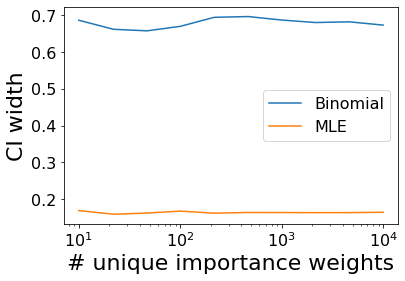

In [8]:
import pickle
allres = pickle.load(open( "epsilongreedy_ci_numimpsweep.p", "rb" ) )

%matplotlib inline
        
class MegaFlassPlot:
    @staticmethod
    def forpaper():
        import matplotlib.pyplot as plt

        SMALL_SIZE = 16
        MEDIUM_SIZE = 22
        BIGGER_SIZE = 24

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    @staticmethod
    def pic(x, y, label):
        import matplotlib.pyplot as plt
        
        plt.semilogx(x, y, label=label)
        plt.legend()
        
    @staticmethod
    def axeslabel(xlabel, ylabel):
        import matplotlib.pyplot as plt
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    @staticmethod
    def title(title):
        import matplotlib.pyplot as plt
        
        plt.title(title)
        
    @staticmethod
    def savefig(filename):
        import matplotlib.pyplot as plt
        
        plt.savefig(filename, bbox_inches='tight')

MegaFlassPlot.forpaper()
for name, res in allres:
    MegaFlassPlot.pic([ x[0] for x in res], [ x[1][1]['width'] for x in res], label=name)
MegaFlassPlot.axeslabel('# unique importance weights', 'CI width')